<a href="https://colab.research.google.com/github/shadynagy111-eng/Decoding-EGX-Price-Action/blob/Task/Second_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program will use CNNs to predict wether stock is bearish, bullish or neutral based on the visual pattern produced by the GAF.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from pyts.image import GramianAngularField
import os
import shutil
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# 1. Load your Kaggle Dataset
df = pd.read_csv('COMI_price.csv', index_col='Date', parse_dates=True)

# 2. Select a 20-day window
window_size = 20
data_slice = df.iloc[0:window_size]

# We save this as an image for the CNN to learn "visual patterns"
mpf.plot(data_slice, type='candle', style='charles',
         savefig=dict(fname='candlestick_sample.png', dpi=100),
         axisoff=True) # axisoff is key so the CNN doesn't learn numbers

# GAF only uses one price point (usually Close)
close_prices = data_slice['Close'].values.reshape(1, -1)

# Initialize GAF (Summation method is standard for price trends)
# sample_range=(-1, 1) is crucial; GAF works by mapping prices to angles
gaf = GramianAngularField(method='summation', sample_range=(-1, 1))
image_gaf = gaf.fit_transform(close_prices)

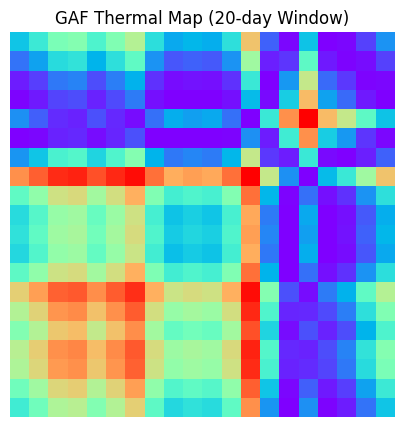

In [4]:
# Display the GAF Heatmap
plt.figure(figsize=(5, 5))
plt.imshow(image_gaf[0], cmap='rainbow', origin='lower')
plt.title("GAF Thermal Map (20-day Window)")
plt.axis('off')
plt.savefig('gaf_sample.png')
plt.show()

In [5]:
for label in ['bullish', 'bearish', 'neutral']:
    os.makedirs(f'dataset/candles/{label}', exist_ok=True)
    os.makedirs(f'dataset/gaf/{label}', exist_ok=True)

In [6]:
# Define your main dataset path
base_path = 'dataset'

# DELETE EVERYTHING and start fresh
if os.path.exists(base_path):
    print(f"Cleaning up old data in {base_path}...")
    shutil.rmtree(base_path)

# Now recreate the folders for the new run
for img_type in ['candles', 'gaf']:
    for label in ['bullish', 'bearish', 'neutral']:
        os.makedirs(f'{base_path}/{img_type}/{label}', exist_ok=True)


# --- CONFIGURATION ---
INPUT_FILE = 'COMI_price.csv'
WINDOW_SIZE = 20  # Task 2 requirement
HORIZON = 5      # Look 5 days ahead to label Bull/Bear
THRESHOLD = 0.01 # 3% change (Adjust this for EGX volatility)

# --- LOAD DATA ---
# Ensure Date is the index and recognized as a date
df = pd.read_csv(INPUT_FILE)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True) # Critical for time-series!

def run_pipeline(df):
    gaf_transformer = GramianAngularField(method='summation', sample_range=(-1, 1))

    # We loop through the data
    for i in range(len(df) - WINDOW_SIZE - HORIZON):
        # 1. Feature Window
        slice_df = df.iloc[i : i + WINDOW_SIZE]

        # 2. Labeling Logic
        current_close = slice_df['Close'].iloc[-1]
        future_close = df['Close'].iloc[i + WINDOW_SIZE + HORIZON]
        change = (future_close - current_close) / current_close

        if change > THRESHOLD:
            label = 'bullish'
        elif change < -THRESHOLD:
            label = 'bearish'
        else:
            label = 'neutral'

        img_name = f"COMI_{i}.png"

        # 3. Save Candlestick (For CNN Pattern Recognition)
        # Use 'binance' or 'charles' style for clear green/red
        mpf.plot(slice_df, type='candle', style='charles', axisoff=True,
                 savefig=dict(fname=f'dataset/candles/{label}/{img_name}', dpi=100))

        # 4. Save GAF (For CNN Mathematical Texture)
        close_vals = slice_df['Close'].values.reshape(1, -1)
        gaf_mtx = gaf_transformer.fit_transform(close_vals)

        # We use 'viridis' or 'rainbow' for the GAF heatmap
        plt.imsave(f'dataset/gaf/{label}/{img_name}', gaf_mtx[0], cmap='rainbow')

    print(f"Finished processing {INPUT_FILE}. Check your 'dataset' folder!")

# Run it
run_pipeline(df)

def check_dataset_balance(base_path='dataset'):
    print("\n--- Dataset Distribution Summary ---")
    for img_type in ['candles', 'gaf']:
        print(f"\nImage Type: {img_type.upper()}")
        total = 0
        counts = {}

        for label in ['bullish', 'bearish', 'neutral']:
            path = os.path.join(base_path, img_type, label)
            count = len(os.listdir(path))
            counts[label] = count
            total += count

        for label, count in counts.items():
            percentage = (count / total) * 100 if total > 0 else 0
            print(f"  {label.capitalize()}: {count} images ({percentage:.1f}%)")

# Call this at the bottom of your script
check_dataset_balance()

Cleaning up old data in dataset...
Finished processing COMI_price.csv. Check your 'dataset' folder!

--- Dataset Distribution Summary ---

Image Type: CANDLES
  Bullish: 1124 images (42.3%)
  Bearish: 921 images (34.7%)
  Neutral: 613 images (23.1%)

Image Type: GAF
  Bullish: 1124 images (42.3%)
  Bearish: 921 images (34.7%)
  Neutral: 613 images (23.1%)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# 1. Image Transformations (Standard for ResNet)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Load your Task 2 Data
data_dir = 'dataset/gaf'
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# Split into Train (80%) and Validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_db, val_db = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_db, batch_size=32, shuffle=True)
val_loader = DataLoader(val_db, batch_size=32, shuffle=False)

# 3. Build the Model (ResNet-18)
model = models.resnet18(weights='IMAGENET1K_V1')

# Freeze the early layers (keep the "pre-trained" knowledge)
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer to match our 3 classes: Bullish, Bearish, Neutral
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

# 4. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# 5. Simple Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Training on {device}...")
for epoch in range(10): # Start with 5 epochs
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


Training on cpu...
Epoch 1 - Loss: 1.1151
Epoch 2 - Loss: 1.0723
Epoch 3 - Loss: 1.0505
Epoch 4 - Loss: 1.0244
Epoch 5 - Loss: 1.0316
Epoch 6 - Loss: 0.9945
Epoch 7 - Loss: 0.9870
Epoch 8 - Loss: 0.9736
Epoch 9 - Loss: 0.9805
Epoch 10 - Loss: 0.9638


In [8]:
torch.save(model.state_dict(), 'comi_resnet_v1.pth')
print("Model saved as comi_resnet_v1.pth")

def evaluate_model(model, loader, device):
    model.eval()  # Set to evaluation mode
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad(): # Disable gradient calculation (saves memory/time)
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # Get the index of the highest score

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy, all_labels, all_preds

# --- After your training loop ---
# 1. Run the evaluation
val_accuracy, labels, preds = evaluate_model(model, val_loader, device)

# 2. Print high-level metrics
print(f"\nFinal Validation Accuracy: {val_accuracy:.2f}%")

# 3. Print the "Deep Insight" Report
target_names = ['Bearish', 'Bullish', 'Neutral'] # Matches ImageFolder alphabetical order
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=target_names))

# 4. Generate Confusion Matrix
cm = confusion_matrix(labels, preds)
print("\nConfusion Matrix (Rows=Actual, Cols=Predicted):")
print(cm)

Model saved as comi_resnet_v1.pth

Final Validation Accuracy: 48.87%

Classification Report:
              precision    recall  f1-score   support

     Bearish       0.43      0.52      0.47       169
     Bullish       0.53      0.71      0.61       242
     Neutral       0.33      0.01      0.02       121

    accuracy                           0.49       532
   macro avg       0.43      0.41      0.36       532
weighted avg       0.45      0.49      0.43       532


Confusion Matrix (Rows=Actual, Cols=Predicted):
[[ 88  80   1]
 [ 70 171   1]
 [ 48  72   1]]
